# Úkol č. 2 - předzpracování dat a binární klasifikace (do 2. listopadu 23:59)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor s predikcemi pro vyhodnocovací data (`results.csv`).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

# Module imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Data loading

In [2]:
train = pd.read_csv('./data/data.csv',index_col='ID')
evaluation = pd.read_csv('./data/evaluation.csv')
data = train.append(evaluation)
data = data.reset_index()

In [3]:
display(data.isnull().sum())

index           0
survived      309
pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
home.dest     564
ID           1000
dtype: int64

# Data preparation
I have decided to rename several columns (mostly abbreviations) to a more verbose description of them, to make them more comprehensible.

In [4]:
data = data.rename(columns={'pclass':'class','sibsp':'siblings/spouses','parch':'parents/children','home.dest':'home/destination'})

data[['surname','forename']] = data['name'].str.split(',',expand = True, n = 1)
data[['title','forename']] = data['forename'].str.split('.',expand = True, n = 1)

data['embarked'].replace({
    'C':'Cherbourg',
    'Q':'Queenstown',
    'S':'Southampton'
},inplace=True)
    
data['deck'] = data[data['cabin'].notna()]['cabin'].str.get(0)
data = data.drop(columns=['name','cabin'])

data = data.reindex(columns=['survived','title','forename','surname','sex','age','class','deck','fare','siblings/spouses','parents/children','ticket','embarked','home/destination'])

## Filling in the blanks
Replacing null values was fairly difficult, as the only indicative lead was my own intuition (and societal customs). As such, null home/destination are not replaced by known values, as that would take gross assumptions to do.
However, age can be approximated much more easily.

In [5]:
data['home/destination'] = data['home/destination'].fillna('Unknown, Unknown')

# filling in missing age values based on groups 
data['age'].fillna(data.groupby(['class','sex','title']).transform('mean')['age'], inplace=True)

print('There is one passenger who is in their own group, and did not get an age value as such')
display(data[ data['age'].isna()])

print('The title is the most restrictive, as we can see, there are only two Ms in the entire dataset, we will drop that criterion') 
display(data[data['title'] == ' Ms'])

data['age'].fillna(data.groupby(['class','sex']).transform('mean')['age'], inplace=True)

There is one passenger who is in their own group, and did not get an age value as such


survived title  forename     surname     sex  age  class deck  fare  \
583       0.0    Ms   Bridget  O'Donoghue  female  NaN      3  NaN  7.75   

     siblings/spouses  parents/children  ticket    embarked  home/destination  
583                 0                 0  364856  Queenstown  Unknown, Unknown

The title is the most restrictive, as we can see, there are only two Ms in the entire dataset, we will drop that criterion


survived title      forename     surname     sex   age  class deck  \
441       1.0    Ms   Encarnacion    Reynaldo  female  28.0      2  NaN   
583       0.0    Ms       Bridget  O'Donoghue  female   NaN      3  NaN   

      fare  siblings/spouses  parents/children  ticket     embarked  \
441  13.00                 0                 0  230434  Southampton   
583   7.75                 0                 0  364856   Queenstown   

     home/destination  
441             Spain  
583  Unknown, Unknown

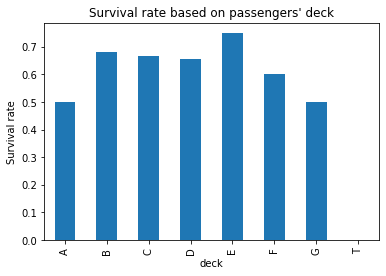

In [6]:
data[['deck','survived']].groupby('deck')['survived'].mean().plot(kind='bar')
plt.title("Survival rate based on passengers' deck")
plt.xlabel('deck')
plt.ylabel('Survival rate')
plt.show()

As passenger's deck is heavily tied to the class they travel in, the empty values could be based on class allegiance. But to avoid overfitting, I have chosen not to do so, rather to mark them as unknown.

In [7]:
display(data.groupby(['class','deck']).size())
data['deck'] = data['deck'].fillna('U')

class  deck
1      A       22
       B       65
       C       94
       D       40
       E       34
       T        1
2      D        6
       E        4
       F       13
3      E        3
       F        8
       G        5
dtype: int64

Missing embark data has been filled in based on real records
* [Amelia Icard](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)
* [Martha Evelyn Stone](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)

In [8]:
data.at[218,'embarked'] = 'Southampton'
data.at[346,'embarked'] = 'Southampton'

In [9]:
display(data.isnull().sum())

survived            309
title                 0
forename              0
surname               0
sex                   0
age                   0
class                 0
deck                  0
fare                  1
siblings/spouses      0
parents/children      0
ticket                0
embarked              0
home/destination      0
dtype: int64

Encode gender as numeric values

In [10]:
data['sex'].replace({
    'male': 1,
    'female':0
},inplace=True)


In [11]:
train = data.iloc[:len(train),:]
evaluation = data.iloc[len(train):,:]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(train)
    display(evaluation)

survived          title  \
0         1.0             Mr   
1         1.0           Miss   
2         0.0           Miss   
3         0.0             Mr   
4         0.0           Miss   
5         0.0             Mr   
6         0.0             Mr   
7         1.0            Mrs   
8         0.0             Mr   
9         0.0             Mr   
10        0.0             Mr   
11        0.0             Mr   
12        0.0             Mr   
13        0.0             Mr   
14        0.0             Mr   
15        0.0           Miss   
16        1.0           Miss   
17        1.0           Miss   
18        0.0             Mr   
19        0.0             Mr   
20        1.0           Miss   
21        0.0             Mr   
22        0.0            Mrs   
23        1.0           Miss   
24        1.0            Mrs   
25        0.0             Mr   
26        1.0            Mrs   
27        1.0            Mrs   
28        0.0             Mr   
29        0.0         Master   
30        1.0           Miss   
31        0.0             Mr   
32        0.0             Mr   
33        1.0             Mr   
34        1.0           Miss   
35        0.0             Mr   
36        1.0         Master   
37        0.0             Mr   
38        0.0             Mr   
39        0.0             Mr   
40        0.0             Mr   
41        0.0             Mr   
42        0.0             Mr   
43        0.0            Rev   
44        0.0           Miss   
45        1.0            Mrs   
46        1.0           Miss   
47        1.0            Mrs   
48        1.0             Mr   
49        0.0             Mr   
50        0.0             Mr   
51        1.0             Mr   
52        0.0             Mr   
53        0.0             Mr   
54        0.0             Mr   
55        1.0            Mrs   
56        1.0            Mrs   
57        1.0           Miss   
58        1.0         Master   
59        0.0           Miss   
60        1.0            Mrs   
61        1.0            Mrs   
62        0.0         Master   
63        0.0             Mr   
64        0.0           Miss   
65        0.0         Master   
66        0.0             Mr   
67        1.0            Mrs   
68        0.0             Mr   
69        1.0            Mrs   
70        1.0            Mrs   
71        0.0             Mr   
72        0.0             Mr   
73        0.0             Mr   
74        0.0             Mr   
75        0.0             Mr   
76        1.0             Mr   
77        1.0             Mr   
78        0.0             Mr   
79        1.0           Miss   
80        1.0            Mrs   
81        1.0            Mrs   
82        0.0             Mr   
83        1.0             Mr   
84        1.0           Miss   
85        1.0           Miss   
86        1.0            Mrs   
87        0.0           Miss   
88        1.0           Miss   
89        0.0             Mr   
90        1.0           Miss   
91        0.0           Miss   
92        0.0             Mr   
93        1.0             Mr   
94        0.0             Mr   
95        0.0             Mr   
96        1.0             Mr   
97        0.0             Mr   
98        0.0             Mr   
99        1.0            Mrs   
100       0.0             Mr   
101       0.0            Mrs   
102       0.0             Mr   
103       0.0            Mrs   
104       0.0             Mr   
105       0.0             Mr   
106       0.0             Mr   
107       1.0            Mrs   
108       1.0            Mrs   
109       1.0           Miss   
110       0.0             Mr   
111       0.0             Mr   
112       0.0             Mr   
113       0.0           Miss   
114       1.0           Miss   
115       1.0         Master   
116       0.0             Mr   
117       0.0             Mr   
118       0.0             Mr   
119       0.0             Mr   
120       0.0             Mr   
121       1.0             Mr   
122       0.0            Mrs   
123       0.0           Miss   
124  

survived    title                                           forename  \
1000       NaN      Mrs                Sidney Samuel (Amy Frances Christy)   
1001       NaN     Miss                                       Julie Rachel   
1002       NaN       Mr                                              Harry   
1003       NaN      Mrs                              Neal (Eileen O'Leary)   
1004       NaN      Mrs                    Benjamin (Ellen Truelove Arman)   
1005       NaN     Miss                                               Ruth   
1006       NaN     Miss                                         Ida Livija   
1007       NaN       Mr                                              James   
1008       NaN       Mr                                            Ervin G   
1009       NaN       Mr                                              Lalio   
1010       NaN       Mr                                  Edwin "Frederick"   
1011       NaN       Mr                                           Benjamin   
1012       NaN       Mr                                             George   
1013       NaN       Mr                                              Vasil   
1014       NaN     Miss                                   Constance Mirium   
1015       NaN       Mr                                             Robert   
1016       NaN       Mr                                    Jacob Christian   
1017       NaN       Mr                         Pehr Fabian Oliver Malkolm   
1018       NaN     Miss                                     Ellen "Nellie"   
1019       NaN   Master                               Clarence Gustaf Hugo   
1020       NaN       Mr                                      George Edward   
1021       NaN       Mr                              John Irwin ("Irving")   
1022       NaN     Miss                        Elizabeth Gladys "Millvina"   
1023       NaN     Miss                                      Hanora "Nora"   
1024       NaN       Mr                                              Mirko   
1025       NaN     Miss                                              Manca   
1026       NaN     Miss                                         Treasteall   
1027       NaN       Mr                                               Ilia   
1028       NaN       Mr                                            Anthony   
1029       NaN       Mr                                  Edward Pennington   
1030       NaN       Mr                                          Joseph Jr   
1031       NaN       Mr                                             Daniel   
1032       NaN     Miss                                          Constance   
1033       NaN       Mr                                              Kanio   
1034       NaN       Mr                                             Uscher   
1035       NaN       Mr                                 Johannes Halvorsen   
1036       NaN       Mr                                      Escott Robert   
1037       NaN      Mrs                               William H (Jessie L)   
1038       NaN       Mr                                    William Bertram   
1039       NaN   Master                                         John Borie   
1040       NaN       Mr                                    Alexander Oskar   
1041       NaN     Miss                               Robina Maggie "Ruby"   
1042       NaN       Mr                                          Abraham L   
1043       NaN       Mr                                  Charles Alexander   
1044       NaN       Mr                                Samuel James Hayden   
1045       NaN       Mr                                             Johann   
1046       NaN      Mrs                  Louis Albert (Ida Sophia Fischer)   
1047       NaN       Mr                                               Leon   
1048       NaN       Mr                                           Theodore   
1049       NaN   Master                                       William Rowe   
1050       NaN       Mr     

#  Model training

Split the input and the signal for adaboosting. My assumption is that the gender, age, class and family (siblings/spouses, parents/children) will be the largest factors in survival rate.

Reasons being ethical and social thinking, such as:
1. Women and children are given a priority
2. Parents will try to save their children rather than themselves
3. Persons of higher class had lodgings on the upper decks - which can be seen from the dataframe slice below, and as such, were faster to reach the lifeboats.

My personal prediction is that children, the rich, and women will have the highest survival rate.

In [12]:
display(train.groupby(['class','deck']).size())

class  deck
1      A        16
       B        50
       C        72
       D        28
       E        25
       U        48
2      D         4
       E         4
       F        12
       U       190
3      E         3
       F         8
       G         4
       U       536
dtype: int64

In [14]:
y = train['survived']
x = train.drop(columns=['survived','title','forename','surname','fare','home/destination','deck','ticket','embarked'])
ev_x = evaluation.drop(columns=['survived','title','forename','surname','fare','home/destination','deck','ticket','embarked'])

In [15]:
model = AdaBoostClassifier()

In [16]:
# followed this example https://machinelearningmastery.com/adaboost-ensemble-in-python/
grid = {
        'n_estimators' : [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
       }

cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring='accuracy')
grid_result = grid_search.fit(x,y)

In [38]:
display("Best {}, using {} parameters".format(grid_result.best_score_,grid_result.best_params_))

"Best 0.7896666666666667, using {'learning_rate': 0.1, 'n_estimators': 200} parameters"

# Prediction

In [33]:
prediction = grid_search.predict(ev_x)
result = pd.DataFrame(prediction, columns = ['survived'],index=np.arange(1000, 1000 + len(ev_x)))
result.index.name = 'ID'

In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(result)

survived
ID            
1000       1.0
1001       1.0
1002       0.0
1003       1.0
1004       1.0
1005       1.0
1006       1.0
1007       0.0
1008       0.0
1009       0.0
1010       0.0
1011       0.0
1012       0.0
1013       0.0
1014       1.0
1015       0.0
1016       0.0
1017       0.0
1018       1.0
1019       0.0
1020       0.0
1021       0.0
1022       0.0
1023       1.0
1024       0.0
1025       1.0
1026       1.0
1027       0.0
1028       0.0
1029       0.0
1030       0.0
1031       0.0
1032       1.0
1033       0.0
1034       0.0
1035       0.0
1036       0.0
1037       1.0
1038       0.0
1039       1.0
1040       0.0
1041       1.0
1042       0.0
1043       0.0
1044       0.0
1045       0.0
1046       1.0
1047       0.0
1048       0.0
1049       1.0
1050       0.0
1051       1.0
1052       0.0
1053       1.0
1054       0.0
1055       1.0
1056       0.0
1057       1.0
1058       0.0
1059       1.0
1060       0.0
1061       1.0
1062       1.0
1063       1.0
1064       0.0
1065       0.0
1066       1.0
1067       0.0
1068       0.0
1069       0.0
1070       0.0
1071       1.0
1072       0.0
1073       0.0
1074       1.0
1075       0.0
1076       1.0
1077       1.0
1078       0.0
1079       0.0
1080       1.0
1081       0.0
1082       0.0
1083       1.0
1084       1.0
1085       0.0
1086       0.0
1087       0.0
1088       1.0
1089       1.0
1090       0.0
1091       1.0
1092       0.0
1093       0.0
1094       0.0
1095       0.0
1096       0.0
1097       1.0
1098       0.0
1099       0.0
1100       1.0
1101       0.0
1102       0.0
1103       0.0
1104       1.0
1105       0.0
1106       1.0
1107       0.0
1108       0.0
1109       0.0
1110       0.0
1111       0.0
1112       1.0
1113       1.0
1114       0.0
1115       0.0
1116       0.0
1117       1.0
1118       0.0
1119       0.0
1120       1.0
1121       0.0
1122       0.0
1123       0.0
1124       0.0
1125       0.0
1126       0.0
1127       0.0
1128       1.0
1129       0.0
1130       1.0
1131       0.0
1132       0.0
1133       0.0
1134       1.0
1135       0.0
1136       0.0
1137       1.0
1138       0.0
1139       0.0
1140       0.0
1141       1.0
1142       1.0
1143       0.0
1144       1.0
1145       0.0
1146       0.0
1147       1.0
1148       0.0
1149       0.0
1150       0.0
1151       1.0
1152       1.0
1153       0.0
1154       0.0
1155       0.0
1156       0.0
1157       1.0
1158       0.0
1159       0.0
1160       0.0
1161       1.0
1162       0.0
1163       0.0
1164       1.0
1165       0.0
1166       1.0
1167       0.0
1168       1.0
1169       1.0
1170       0.0
1171       1.0
1172       0.0
1173       0.0
1174       0.0
1175       1.0
1176       0.0
1177       0.0
1178       1.0
1179       1.0
1180       0.0
1181       0.0
1182       1.0
1183       0.0
1184       1.0
1185       1.0
1186       0.0
1187       0.0
1188       0.0
1189       0.0
1190       0.0
1191       0.0
1192       0.0
1193       1.0
1194       1.0
1195       0.0
1196       0.0
1197       0.0
1198       0.0
1199       0.0
1200       1.0
1201       0.0
1202       0.0
1203       0.0
1204       0.0
1205       0.0
1206       0.0
1207       0.0
1208       0.0
1209       0.0
1210       0.0
1211       0.0
1212       0.0
1213       0.0
1214       0.0
1215       0.0
1216       1.0
1217       0.0
1218       1.0
1219       0.0
1220       0.0
1221       0.0
1222       0.0
1223       0.0
1224       0.0
1225       1.0
1226       1.0
1227       0.0
1228       1.0
1229       0.0
1230       0.0
1231       1.0
1232       0.0
1233       1.0
1234       0.0
1235       1.0
1236       0.0
1237       0.0
1238       0.0
1239       0.0
1240       1.0
1241       0.0
1242       0.0
1243       1.0
1244       1.0
1245       0.0
1246       0.0
1247       0.0
1248       1.0
1249       0.0
1250       0.0
1251       0.0
1252       1.0
1253       0.0
1254       0.0
1255       0.0
1256       1.0
1257       1.0
1258       0.0
1259       0.0
1260       0.0
1261       1.0
1262       0.0
1263       0.0
1264       0.0
1

In [37]:
result.to_csv('./data/results.csv')